In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt   
from pandas.plotting import register_matplotlib_converters
from utilities.base import BaseData
from utilities.utils import geo_mean, sum_day
register_matplotlib_converters()

In [8]:
df = BaseData().get_filled_df()
df.head(1)

/Users/user/Desktop/RANEPA_lec_24_03/venv/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,category_id,category_title,date,miss,price_old,site_code,site_link,site_title,site_unit,type,price_new,nsprice_f
id,,,,,,,,,,,,
0,10,"Молоко питьевое цельное пастеризованное 2,5-3,...",2019-02-05,0,-1.0,globus,https://online.globus.ru/products/moloko-36-ko...,"Молоко пастеризованное 36 Копеек 3,2%, 485 мл",за 1 шт.,food,34.89,34.89


In [9]:
df = df[df.category_id!=76]
# df = df[df.site_code!='ozon']
df.loc[:,'unq'] = df.category_id.astype(str) + df.site_link
df.loc[:,'date'] = pd.to_datetime(df.date)
df = df[df.miss==0]
df = df.drop(columns=['category_title','site_title','site_unit',
                      'site_link','price_new','miss','price_old','site_code'])
# type_ = 'food'
# df = df[df.type==type_]
srs = df.groupby('unq')['nsprice_f'].transform(lambda x: x.pct_change()+1)
df.loc[:,'cng_price'] = srs
# df = df.drop(columns=['nsprice_f'])

pvt_df = df.pivot_table(index='date', columns='category_id', aggfunc=geo_mean).loc[:,'cng_price'].iloc[1:]
pvt_df.iloc[0,:] = 1
pvt_df = pvt_df.fillna(method='ffill').apply(lambda x: x.cumprod(), axis=0).dropna(how='all')

wt_srs = pd.read_csv(r'~/PycharmProjects/ane_django/parser_app/logic/description/categories.csv', index_col='id', sep=';').iloc[:-1,:]['cpi_weight']
wt_srs.index = wt_srs.index.astype(int)
cpi_online = pvt_df.apply(lambda input_srs: sum_day(wt_srs, input_srs), axis=1)
date_srs = pd.Series(index=pd.date_range(start=cpi_online.index[0], end=cpi_online.index[-1])).to_frame().drop(columns=0)
cpi_online = cpi_online.to_frame().merge(date_srs, left_index=True, right_index=True, how='right').fillna(method='ffill')

ipykernel_launcher:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [10]:
cpi_of = pd.read_csv(f'~/cpi_common.csv',index_col='date', sep=';')
cpi_of.index = pd.to_datetime(cpi_of.index,format='%d.%m.%Y')
cpi_of = (cpi_of/100)
cpi_of = cpi_of.iloc[1:]
cpi_of.iloc[0] = 1
cpi_of = cpi_of.cumprod()
cpi_of = cpi_of.merge(date_srs, left_index=True, right_index=True, how='right').fillna(method='ffill')

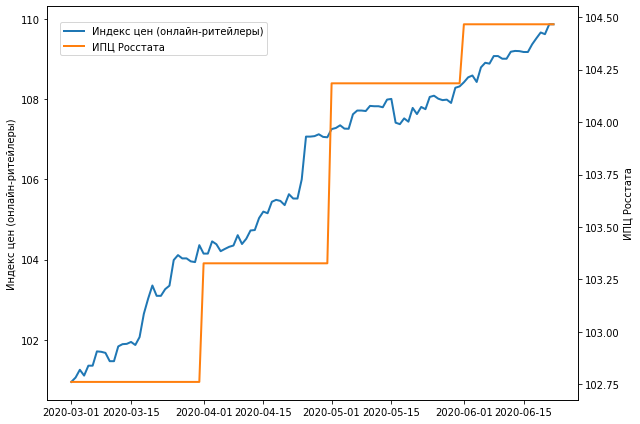

In [9]:
date_range2020 = pd.date_range(start='2020-03-01', end='2020-06-22')
# plt.plot(date_range,cpi_of.loc[date_range,:]);
# plt.plot(date_range,cpi_online.loc[date_range]);
# cpi_online


fig, ax1 = plt.subplots(figsize=(9,6)) # plt.subplots(figsize=(9,6))
# cond1 = (cpi_online.index>'2020-03-01')&(cpi_online.index<'2020-06-20')
ax1.set_ylabel('Индекс цен (онлайн-ритейлеры)')
ax1.plot(cpi_online.loc[date_range2020,:]*100, lw=2);
# ax1.plot(cpi_of, color=color_cpi, ls='--', lw=3);
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('ИПЦ Росстата')
ax2.plot(cpi_of.loc[date_range2020,:]*100, ls='-', color="#ff7f0e",lw=2);
ax2.tick_params(axis='y')

fig.legend(['Индекс цен (онлайн-ритейлеры)','ИПЦ Росстата'], loc='upper left', bbox_to_anchor=(0.09,0.95))
fig.tight_layout()

# plt.grid(axis='y')
plt.show()

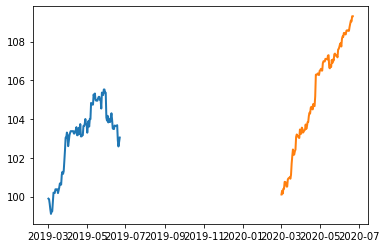

In [19]:
from datetime import datetime
date_range2019 = pd.date_range(start='2019-03-01', end='2019-06-22')
date_range2020 = pd.date_range(start='2020-03-01', end='2020-06-22')
plt.plot((cpi_online.loc[date_range2019,:].diff()+1).cumprod()*100, lw=2);
# plt.show();
plt.plot((cpi_online.loc[date_range2020,:].diff()+1).cumprod()*100, lw=2);

In [31]:
# export CPI offline and CPI online to excel
df_toexcel = cpi_online.merge(cpi_of, left_index=True, right_index=True)
df_toexcel.columns = ['Продовольственный ИПЦ Онлайн', 'Продовольственный ИПЦ Росстат']
df_toexcel

,Продовольственный ИПЦ Онлайн,Продовольственный ИПЦ Росстат
2019-02-01,1.000000,1.000000
2019-02-02,1.003908,1.000000
2019-02-03,1.003908,1.000000
2019-02-04,1.007858,1.000000
2019-02-05,1.012493,1.000000
...,...,...
2021-03-16,1.130835,1.064341
2021-03-17,1.128123,1.064341
2021-03-18,1.127224,1.064341
2021-03-19,1.134444,1.064341
